In [14]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
pd.options.display.max_colwidth = 300

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [15]:
data = pd.read_csv('text.csv')
data = data.drop(columns=['Unnamed: 0'])

mapping = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
data['label_mapped'] = data['label'].map(mapping)

print('data shape ---> ', data.shape)
data.head(3)

data shape --->  (416809, 3)


,text,label,label_mapped
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing,0,sadness
2,i gave up my internship with the dmrg and am feeling distraught,4,fear


In [16]:
# Drop duplicates

def find_duplicate_text(df, column_name):
    duplicated_text = df[df.duplicated(subset=[column_name], keep='first')][column_name].tolist()
    return duplicated_text

dup_text = find_duplicate_text(data,'text')
drop_dup_df = data.drop_duplicates(subset=['text'])

print(f"data shape after removing duplicates: {drop_dup_df.shape}")
print(f"data shape befor removing duplicates: {data.shape}")

data shape after removing duplicates: (393822, 3)
data shape befor removing duplicates: (416809, 3)


In [17]:
# Remove HTML tags and special characters.
def clean_text_column(df, column_name):
    df = df.copy()
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'<.*?>', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\bim\b', '', x, flags=re.IGNORECASE))
    return df

drop_s_df = clean_text_column(drop_dup_df,'text')
drop_s_df.head(3)

,text,label,label_mapped
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing,0,sadness
2,i gave up my internship with the dmrg and am feeling distraught,4,fear


In [18]:
# Lowercasing & stopword & punctuation removing
def preprocess_text(df, column_name):
    df[column_name] = df[column_name].str.lower()
    df[column_name] = df[column_name].apply(nltk.word_tokenize)
    stop_words = set(stopwords.words('english'))
    df[column_name] = df[column_name].apply(lambda tokens: [token for token in tokens if token not in stop_words])# stopwords
    df[column_name] = df[column_name].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])#punctuation
    df[column_name] = df[column_name].apply(' '.join)
    
    return df
data_prep =preprocess_text(drop_s_df, 'text')
data_prep.head(3)

,text,label,label_mapped
0,feel really helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly needed last weeks around end uni expo lately started find feeling bit listless never really good thing,0,sadness
2,gave internship dmrg feeling distraught,4,fear


In [19]:
def text_properties(df):
    df = df.copy()
    df['num_characters']= df['text'].apply(len) 
    df['text'].apply(lambda x: nltk.word_tokenize(x))
    df['num_words']= df['text'].apply(lambda x:len(nltk.word_tokenize(x))) 
    return df 

In [20]:
df_prop = text_properties(data_prep)
df_prop.head(3)
df_filtered = df_prop[df_prop['num_characters'] != 0]
df_filtered.shape, df_prop.shape

After text_cleaning , some texts that contained only one word became blank: 



((393813, 5), (393822, 5))

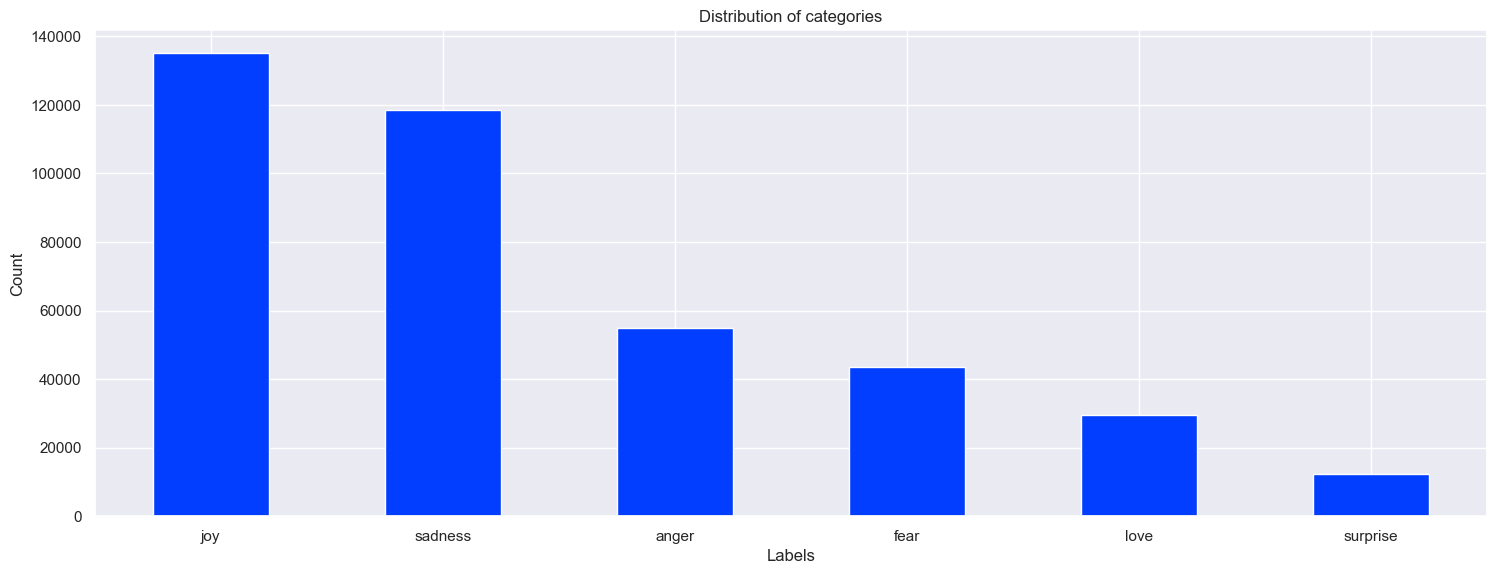

In [34]:
plt.figure(figsize=(16, 6))
data_prep.label_mapped.value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of categories')
plt.xticks(rotation=0) 
plt.show()

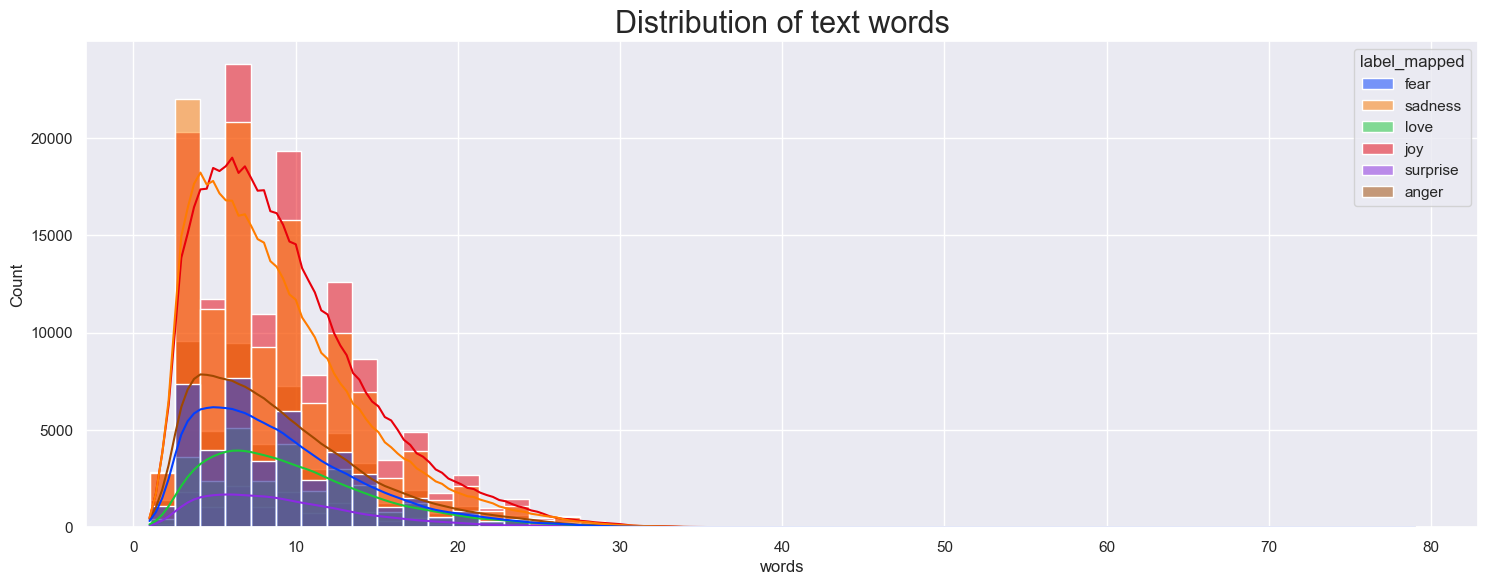

In [22]:
sns.set_theme(rc={'figure.figsize':(16,6)})

sns.set_palette("bright")
sns.histplot(df_filtered, x='num_words',hue='label_mapped' ,bins=50, kde=True)
plt.title('Distribution of text words',fontsize=22)
plt.xlabel('words')
plt.ylabel('Count')
plt.show()

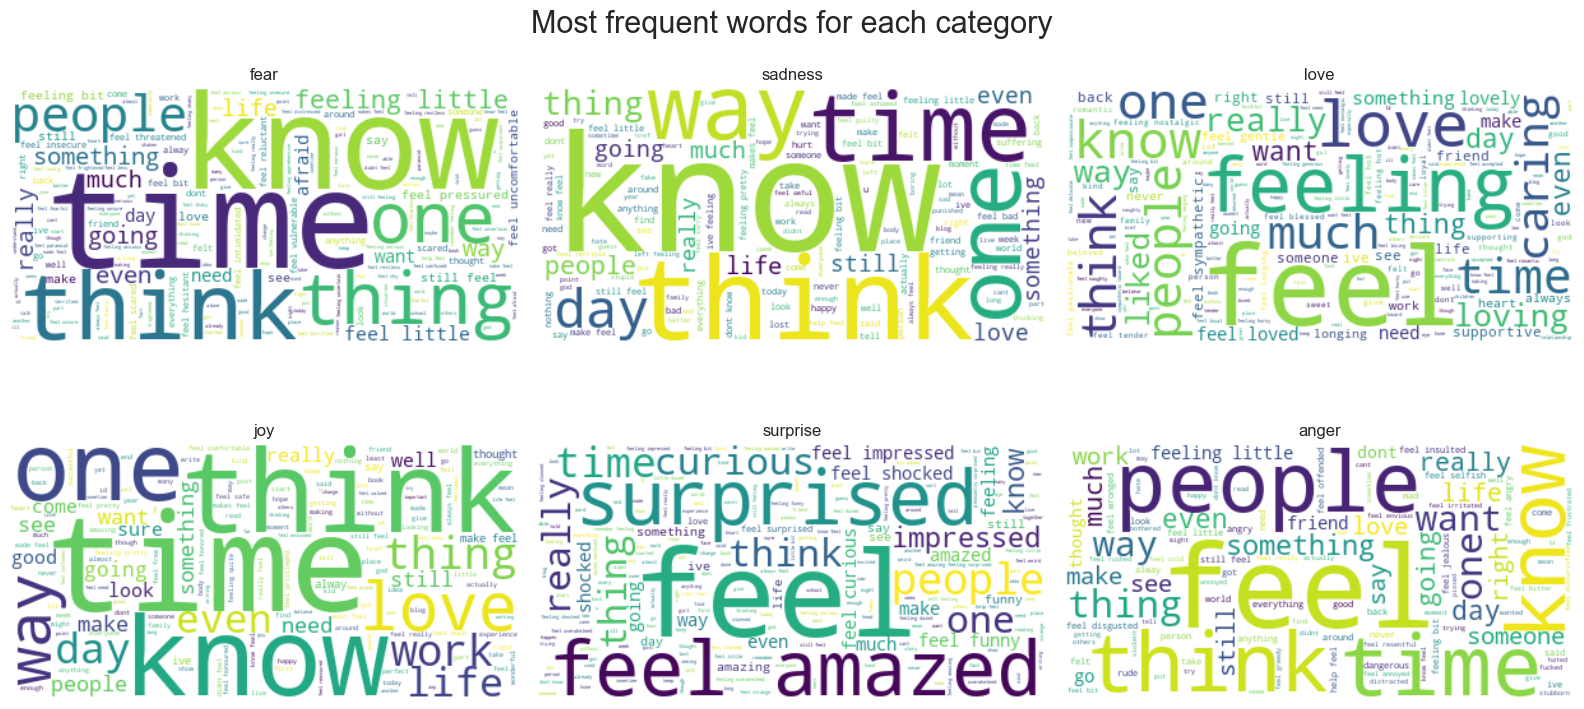

In [24]:
unique_classes = df_filtered['label_mapped'].unique()

num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

for i, label in enumerate(unique_classes):
    row = i // num_cols
    col = i % num_cols
    
    texts_for_class = df_filtered[df_filtered['label_mapped'] == label]['text']
    
    all_text_for_class = ' '.join(texts_for_class)
    
    wordcloud = WordCloud(background_color='white').generate(all_text_for_class)
    
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

plt.tight_layout()
plt.suptitle('Most frequent words for each category',fontsize=22)
plt.show()

Most 10 frequent words for each category : 



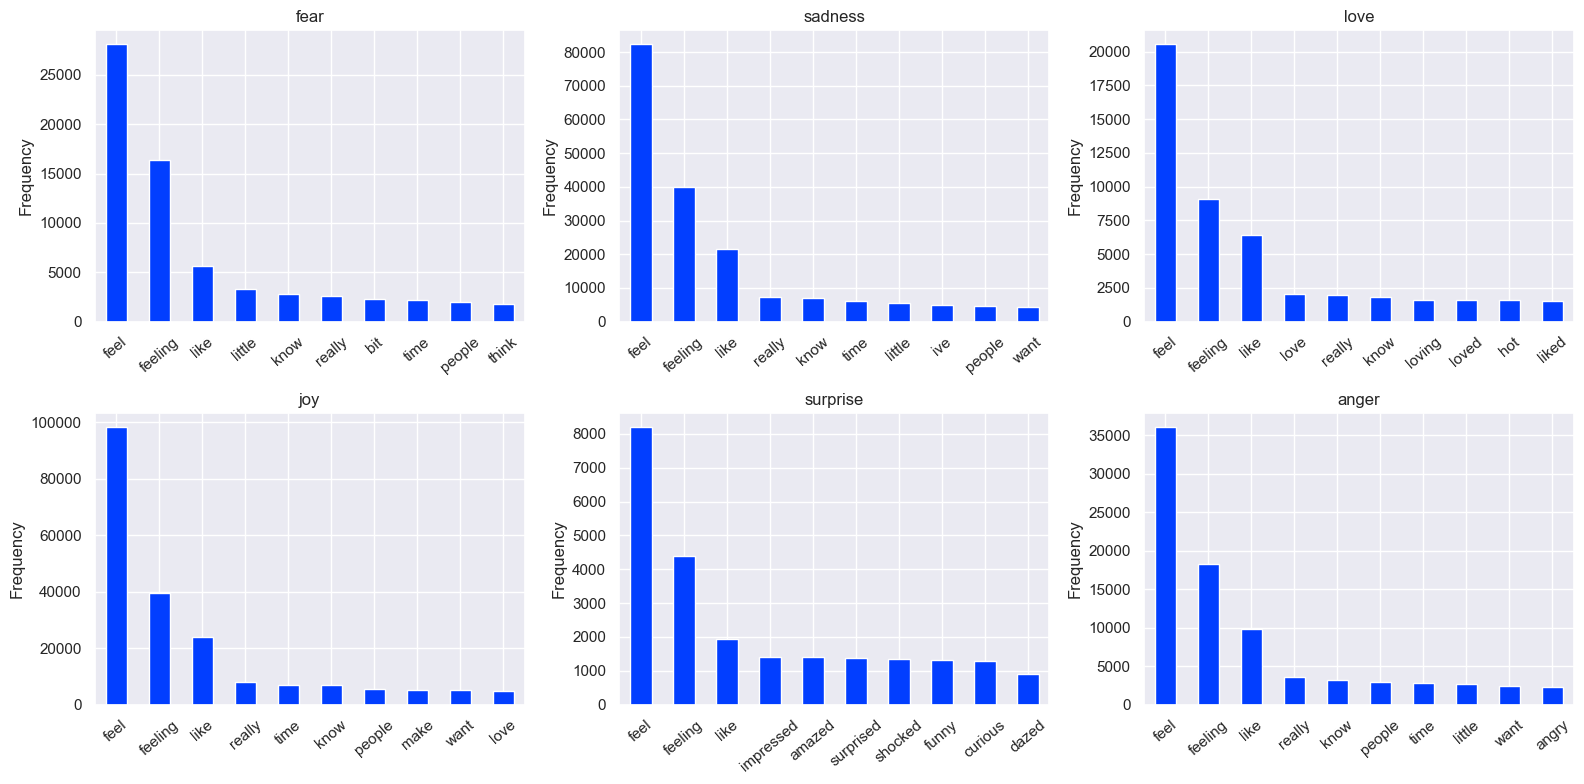

In [25]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

for i, label in enumerate(unique_classes):
    row = i // num_cols
    col = i % num_cols
    
    texts_for_class = df_filtered[df_filtered['label_mapped'] == label]['text']
    
    word_counts = vectorizer.fit_transform(texts_for_class)
    top_words = pd.DataFrame(word_counts.sum(axis=0), columns=vectorizer.get_feature_names_out())
    top_words = top_words.transpose().sort_values(0, ascending=False).head(10)
    
    top_words.plot(kind='bar', ax=axes[row, col], legend=False)
    axes[row, col].set_title(label)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].tick_params(axis='x', rotation=40)

plt.tight_layout()
print("Most 10 frequent words for each category : \n")
plt.show()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered['text'], 
                                                    df_filtered['label_mapped'],test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_filtered['label_mapped'])

In [36]:
lr_clf = LogisticRegression(max_iter=200,random_state=42)

count_vector = CountVectorizer()

training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)


In [37]:
lr_clf.fit(training_data, y_train)
predictions = lr_clf.predict(testing_data)

Accuracy score:  0.9327983951855566
Precision score:  0.932850669822032
Recall score:  0.9327983951855566
F1 score:  0.9328215483553904
classification_report: 
               precision    recall  f1-score   support

       anger       0.93      0.93      0.93     10955
        fear       0.90      0.90      0.90      8726
         joy       0.95      0.95      0.95     27006
        love       0.87      0.88      0.87      5893
     sadness       0.95      0.95      0.95     23702
    surprise       0.84      0.84      0.84      2481

    accuracy                           0.93     78763
   macro avg       0.91      0.91      0.91     78763
weighted avg       0.93      0.93      0.93     78763



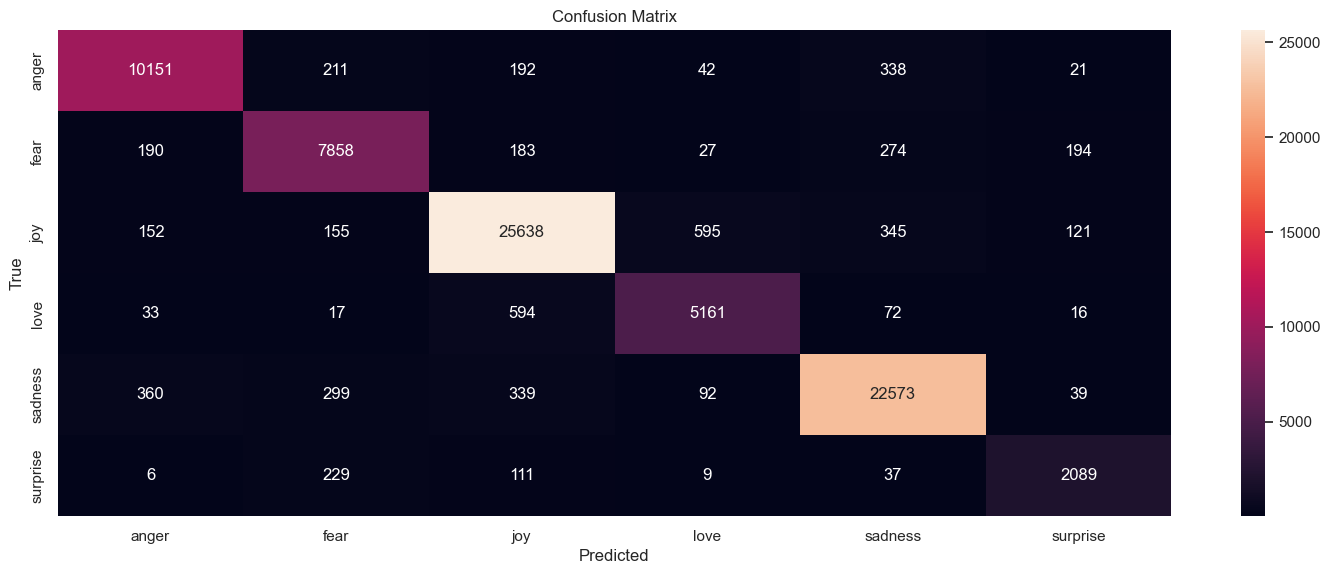

In [30]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions,average='weighted')))
print('Recall score: ', format(recall_score(y_test, predictions,average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions,average='weighted')))
print('classification_report: \n',format(classification_report(y_test, predictions)))

labels=['anger','fear','joy','love','sadness','surprise']
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='d', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Naive Bayes Model
Accuracy score:  0.8937826136637761
Precision score:  0.8961105094724457
Recall score:  0.8937826136637761
F1 score:  0.8893642776021146
classification_report: 
               precision    recall  f1-score   support

       anger       0.93      0.88      0.90     10955
        fear       0.90      0.85      0.87      8726
         joy       0.88      0.95      0.91     27006
        love       0.91      0.69      0.78      5893
     sadness       0.89      0.95      0.92     23702
    surprise       0.96      0.41      0.58      2481

    accuracy                           0.89     78763
   macro avg       0.91      0.79      0.83     78763
weighted avg       0.90      0.89      0.89     78763



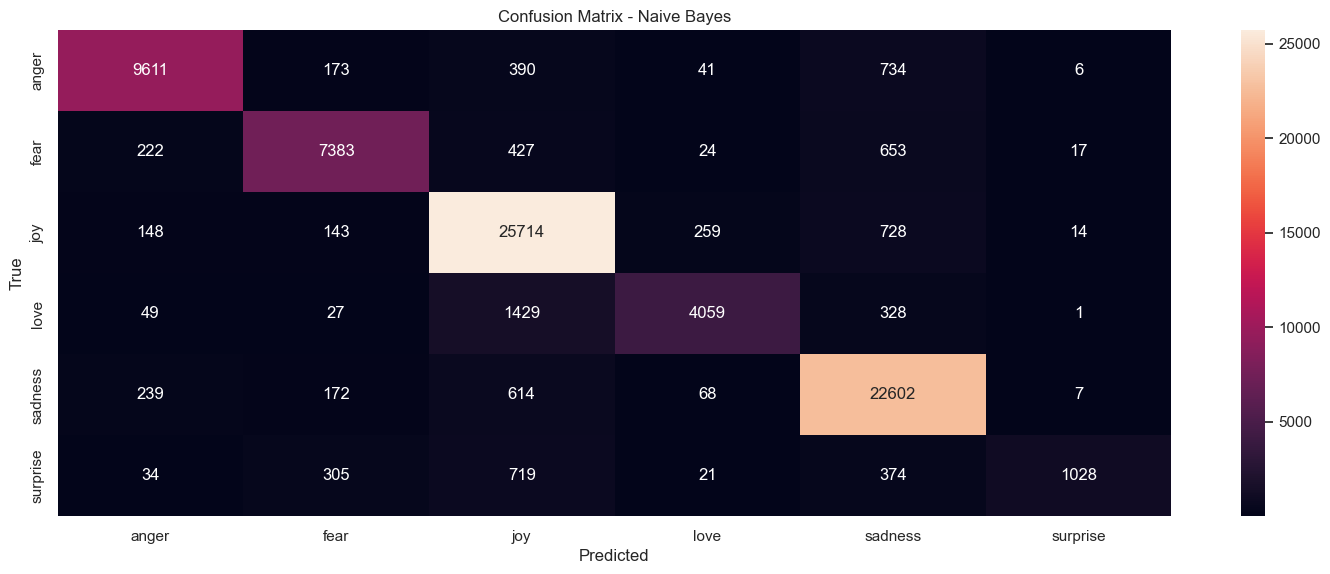

In [32]:
nb_clf = MultinomialNB()

nb_clf.fit(training_data, y_train)

nb_predictions = nb_clf.predict(testing_data)

print('Naive Bayes Model')
print('Accuracy score: ', format(accuracy_score(y_test, nb_predictions)))
print('Precision score: ', format(precision_score(y_test, nb_predictions, average='weighted')))
print('Recall score: ', format(recall_score(y_test, nb_predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, nb_predictions, average='weighted')))
print('classification_report: \n', format(classification_report(y_test, nb_predictions)))

cf_matrix_nb = confusion_matrix(y_test, nb_predictions)
sns.heatmap(cf_matrix_nb, annot=True, fmt='d', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
9846/9846 - 30s - 3ms/step - accuracy: 0.9327 - loss: 0.1737 - val_accuracy: 0.9598 - val_loss: 0.0828
Epoch 2/2
9846/9846 - 33s - 3ms/step - accuracy: 0.9620 - loss: 0.0829 - val_accuracy: 0.9605 - val_loss: 0.0768
2462/2462 - 3s - 1ms/step - accuracy: 0.9605 - loss: 0.0768
Loss: 0.07677341997623444
Accuracy: 0.9605017304420471
2462/2462 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
CNN Model
Accuracy score:  0.9605017584398766
Precision score:  0.9606136129540154
Recall score:  0.9605017584398766
F1 score:  0.960446074037122
classification_report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10955
           1       0.95      0.92      0.94      8726
           2       0.97      0.98      0.97     27006
           3       0.92      0.89      0.90      5893
           4       0.98      0.98      0.98     23702
           5       0.86      0.92      0.89      2481

    accuracy                           0.96     78763
   macro av

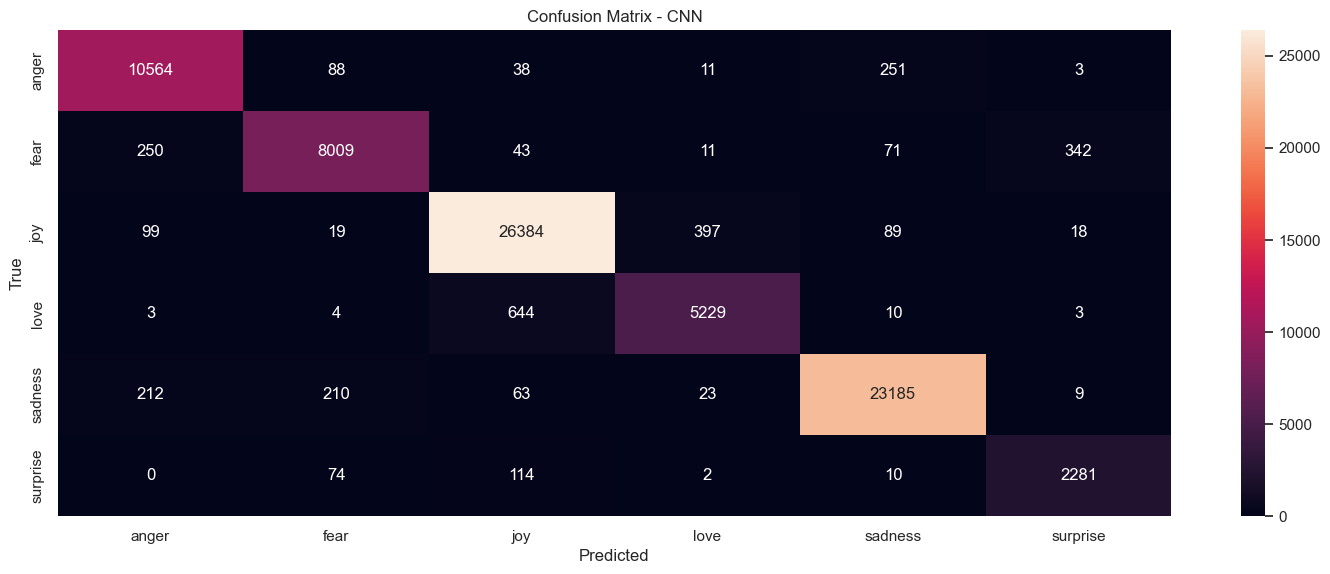

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

vocab_size = 5000 
embedding_dim = 50 
max_length = 100
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(64, 5, activation='relu'), 
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(16, activation='relu'),  
    Dense(6, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(train_padded, y_train_encoded, epochs=2, validation_data=(test_padded, y_test_encoded), verbose=2)  # Reduced epochs for testing

loss, accuracy = model.evaluate(test_padded, y_test_encoded, verbose=2)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

cnn_predictions = model.predict(test_padded)
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)

print('CNN Model')
print('Accuracy score: ', format(accuracy_score(y_test_encoded, cnn_pred_labels)))
print('Precision score: ', format(precision_score(y_test_encoded, cnn_pred_labels, average='weighted')))
print('Recall score: ', format(recall_score(y_test_encoded, cnn_pred_labels, average='weighted')))
print('F1 score: ', format(f1_score(y_test_encoded, cnn_pred_labels, average='weighted')))
print('classification_report: \n', format(classification_report(y_test_encoded, cnn_pred_labels)))

cf_matrix_cnn = confusion_matrix(y_test_encoded, cnn_pred_labels)
sns.heatmap(cf_matrix_cnn, annot=True, fmt='d', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
